In [2]:
from __future__ import print_function, division
#Allows relative imports
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
#imports from files
from src.preprocessing import *
from src.VAE_train import *
from vae_cel.vae_cel import *
from src.embedding_visualisation import * 
from clf.MLP_binary import * 
from clf.clf_train_eval_helpers import *
from src.loss_metrics import *
from src.pickling import *
from src.datasets import *

import pandas as pd 
import numpy as np
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

#checking gpu status
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using : {}".format(device))
else:
    device = torch.device('cpu')
    print("Using : {}".format(device))
    
#Plot and stuff
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi']= 200
sns.set_style('darkgrid')

torch.cuda.empty_cache()
# Ignore warnings)
import warnings
warnings.filterwarnings("ignore")
    
%load_ext autoreload
%autoreload 2

Using : cuda


In [21]:
logregVAE = load_pkl('../output/epitopes_classification/kfold_logreg_dict_VAE.pkl')

In [39]:
top5_AE_RF = load_pkl('../output/epitopes_classification/kfold_top5_AE_rf_dict.pkl')
test.keys(), len(test.keys())

(dict_keys(['GILGFVFTLn_est_300_depth_12', 'GILGFVFTLn_est_200_depth_12', 'GILGFVFTLn_est_300_depth_25', 'GILGFVFTLn_est_200_depth_25', 'GILGFVFTLn_est_100_depth_12', 'NLVPMVATVn_est_300_depth_25', 'NLVPMVATVn_est_200_depth_25', 'NLVPMVATVn_est_100_depth_25', 'NLVPMVATVn_est_300_depth_12', 'NLVPMVATVn_est_200_depth_12', 'YLQPRTFLLn_est_300_depth_12', 'YLQPRTFLLn_est_300_depth_25', 'YLQPRTFLLn_est_200_depth_12', 'YLQPRTFLLn_est_200_depth_25', 'YLQPRTFLLn_est_300_depth_7']),
 15)

In [36]:
# Here, for the epitope GILG... and the fold 1 (0) of the 5-CV
logregVAE['GILGFVFTL'][0][0] # The 3 arrays for the ROC_AUC curve
logregVAE['GILGFVFTL'][0][1] # the AUC of that fold
logregVAE['GILGFVFTL'][0][2] # The "XS" array from the Precision-recall curve
logregVAE['GILGFVFTL'][0][3] # the "Perfecft prediction array" from the PR curve

array([1.        , 1.5       , 1.83333333, ..., 7.49838067, 7.49838067,
       7.49838067])

In [49]:
#For this one, (maybe I messed up and did it differently for RF)
# Here the first index [0] is for the tuple (0 = dict, 1 = the mean AUC)
# so this dict has an extra dimension due to the mean AUC being displayed 
top5_AE_RF['GILGFVFTLn_est_100_depth_12'][0][0][0] # This is the 3 arrays for the ROC AUC CURVE
top5_AE_RF['GILGFVFTLn_est_100_depth_12'][0][0][1] # Then it's the same as above (fold AUC)
top5_AE_RF['GILGFVFTLn_est_100_depth_12'][0][0][2] # Then it's the same as above (Xs array)
top5_AE_RF['GILGFVFTLn_est_100_depth_12'][0][0][3] # Then it's the same as above (perfect array)

array([1.        , 1.5       , 1.83333333, ..., 7.49838067, 7.49838067,
       7.49838067])

In [53]:
kfold_nn = load_pkl('../output/epitopes_classification/KCV/kfold_nn_anotherBinary.pkl')
kfold_nn.keys() 
kfold_nn['GILGFVFTL'][0] # This one is like the LogReg. 
# So some dict have an extra dim, some other don't

((array([0.        , 0.        , 0.        , ..., 0.99184891, 0.99184891,
         1.        ]),
  array([0.00000000e+00, 9.87166831e-04, 7.20631787e-02, ...,
         9.99012833e-01, 1.00000000e+00, 1.00000000e+00]),
  array([1.9989129e+00, 9.9891293e-01, 9.9390680e-01, ..., 4.3543023e-03,
         4.3459623e-03, 1.9567050e-03], dtype=float32)),
 0.856537968634393,
 array([1.        , 1.        , 1.        , ..., 0.04949869, 0.04949422,
        0.04948975]),
 array([1.        , 1.5       , 1.83333333, ..., 7.49838067, 7.49838067,
        7.49838067]))

In [118]:
epitopes = pd.read_csv('../training_data_new/epitopes/epitopes_vj_merged.csv')
len(epitopes[epitopes['epitope']=='GILGFVFTL'])

5033

In [125]:
len(kfold_nn['NLVPMVATV'][2][0][0])

1543

In [96]:
#fold 0
kfold_nn['GILGFVFTL'][0]
#1st element of fold 0, which is the tuple containing the 3 roc_curve arrays
kfold_nn['GILGFVFTL'][0][0]
# 1st element of the tuple of the fold 0  which is the 1st roc_curve array
kfold_nn['GILGFVFTL'][0][0][0]

array([0.        , 0.        , 0.        , ..., 0.99184891, 0.99184891,
       1.        ])

In [103]:
kfold_nn['GILGFVFTL'].keys()

dict_keys([0, 1, 2, 3, 4])

No handles with labels found to put in legend.
No handles with labels found to put in legend.


GILGFVFTL
NLVPMVATV
YLQPRTFLL


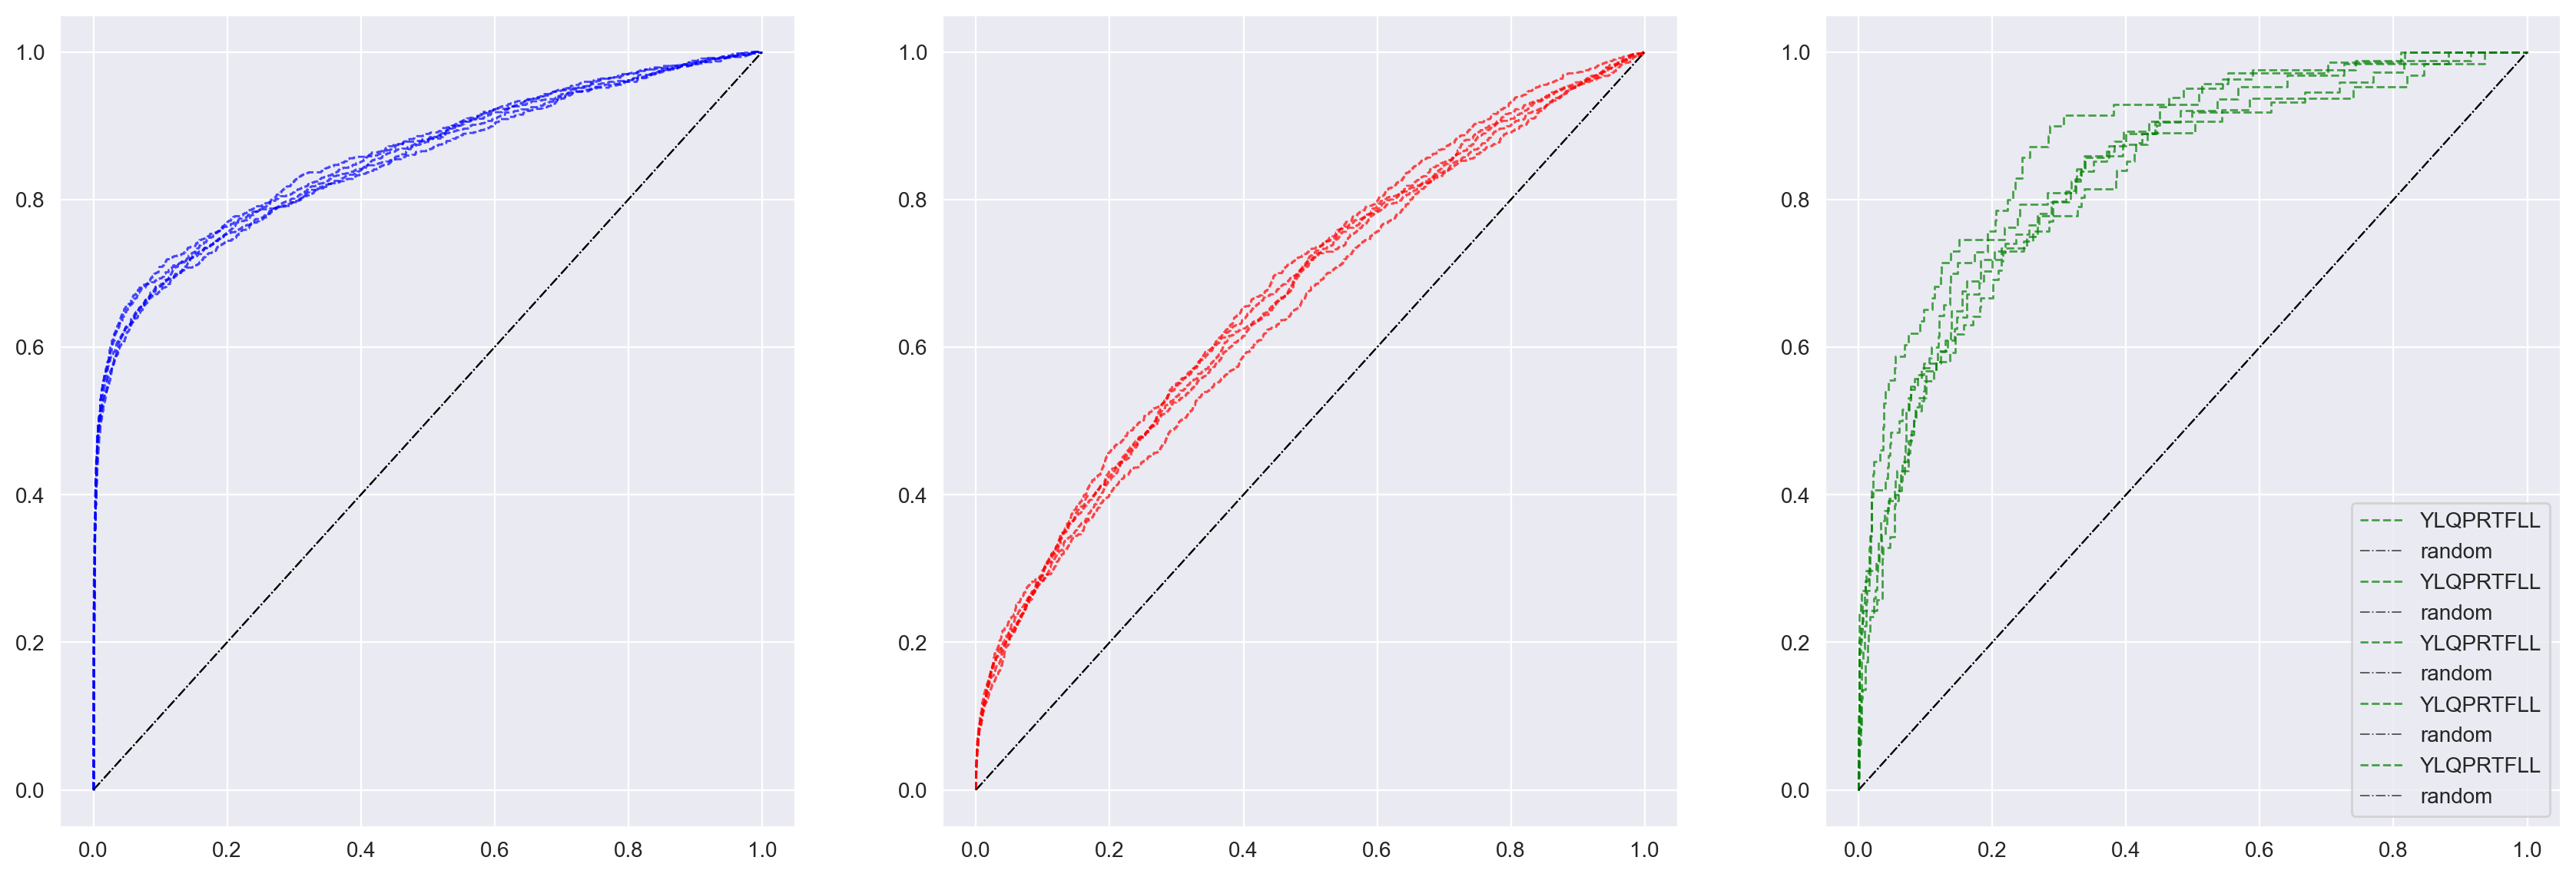

In [161]:
f,a = plt.subplots(1,3, figsize=(21,7))
c = ['b--', 'r--', 'g--']
for i, epitope in enumerate(kfold_nn.keys()):
    print(epitope)
    len_ = len(kfold_nn[epitope][0][0][0])#1st fold, 1st item of the dict, 1st item of the tuple
    curve_0 = np.empty((len_,0))

    for k in kfold_nn[epitope].keys():
        # 3 elements in the curve tuple
        FPR = kfold_nn[epitope][k][0][0] #1st curve
        TPR = kfold_nn[epitope][k][0][1] #2nd curve
        #_ = logregVAE[epitope][k][0][2] #Useless thresholds
        #curve_0 = np.concatenate([curve_0, roc_curve_0], axis=1)
        a[i].plot(FPR, TPR,c[i], alpha = 0.7, lw = 1 , label = epitope)
        base = np.linspace(0,1,250)
        a[i].plot(base, base, 'k-.', alpha = 0.6, lw = .7, label = 'random')
    plt.legend()
    

GILGFVFTLn_est_300_depth_12
NLVPMVATVn_est_300_depth_25
YLQPRTFLLn_est_300_depth_12


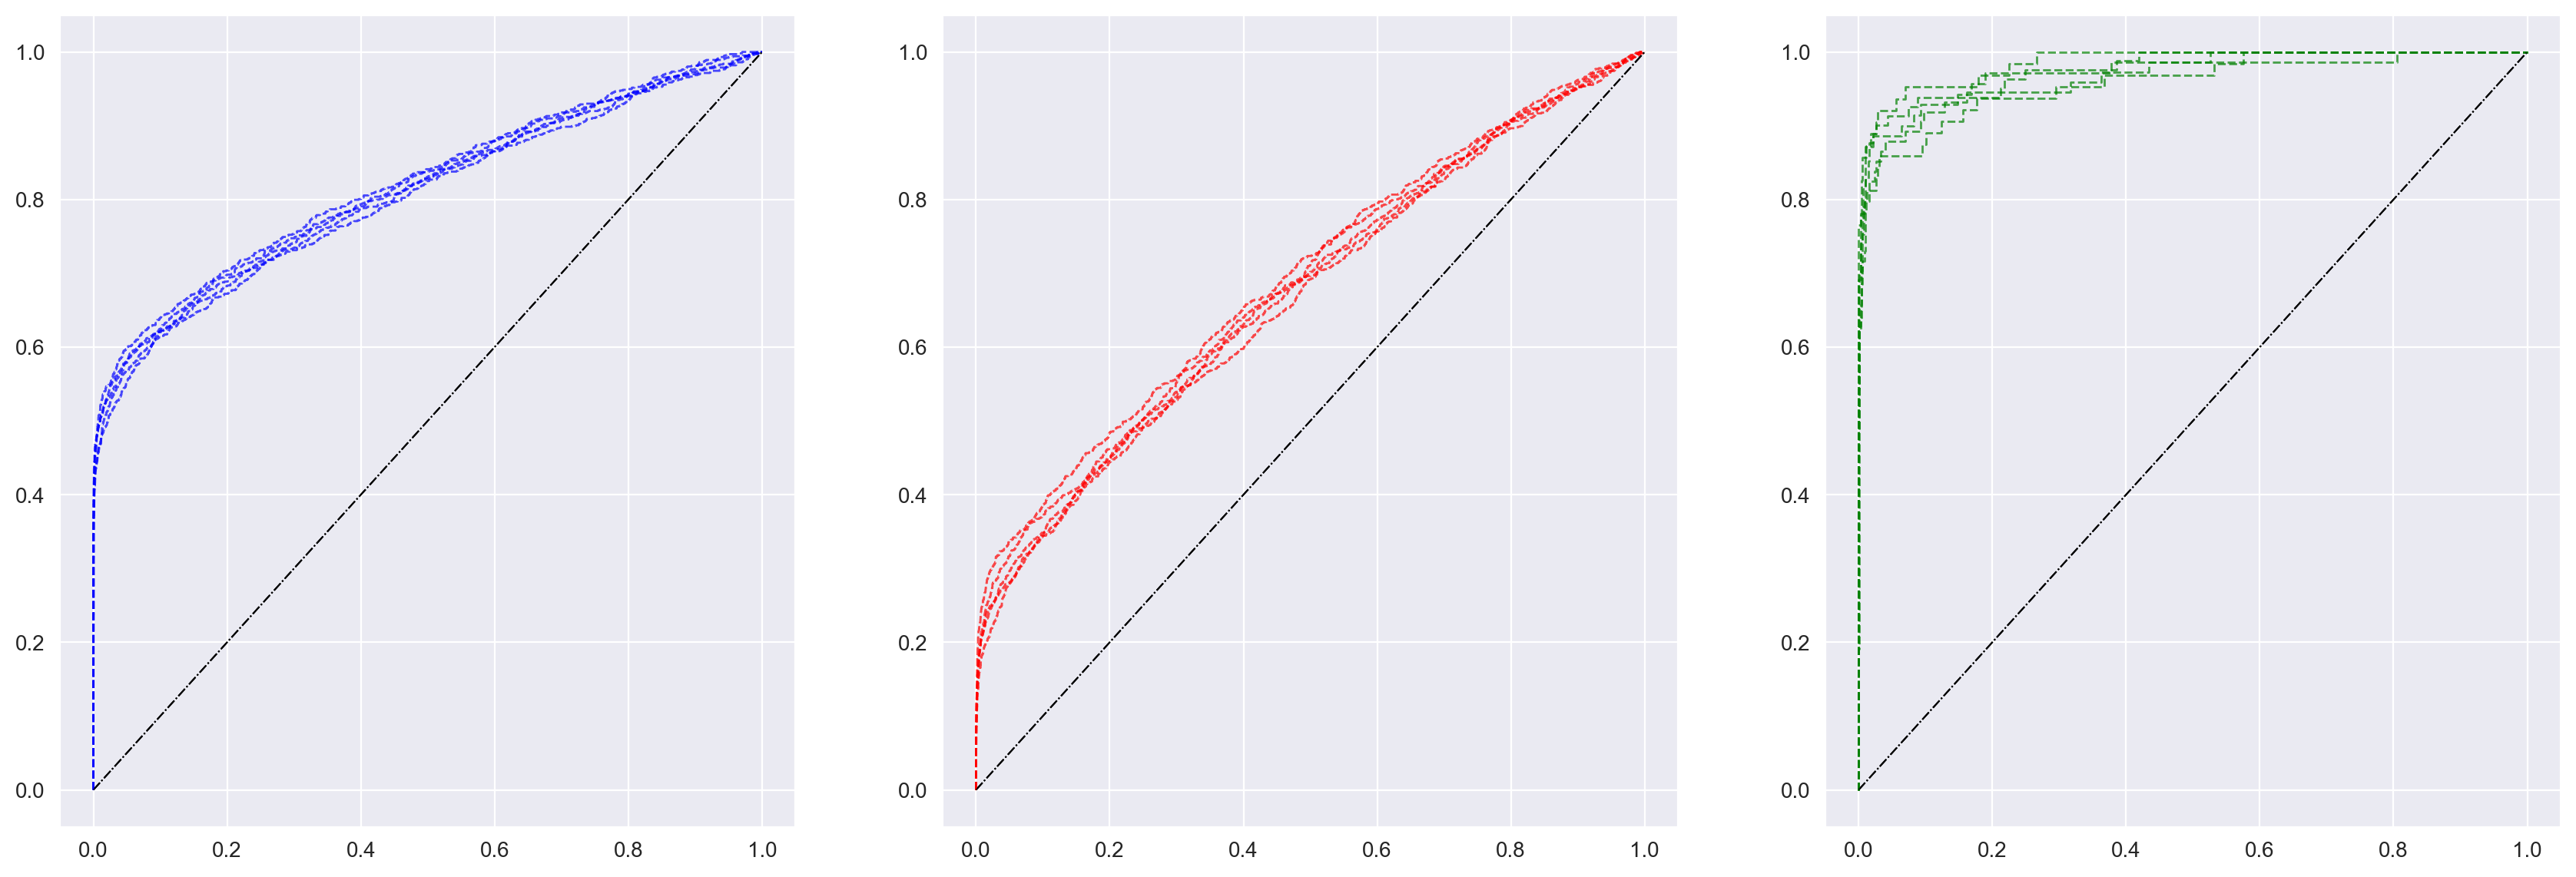

In [170]:
f,a = plt.subplots(1,3, figsize=(21,7))
c = ['b--', 'r--', 'g--']
for i,epitope in enumerate(['GILGFVFTLn_est_300_depth_12', 'NLVPMVATVn_est_300_depth_25', 'YLQPRTFLLn_est_300_depth_12']):
    print(epitope)
    for k in top5_AE_RF[epitope][0].keys():
        FPR = top5_AE_RF[epitope][0][k][0][0]
        TPR = top5_AE_RF[epitope][0][k][0][1]
        a[i].plot(FPR, TPR,c[i], alpha = 0.7, lw = 1 , label = epitope)
        base = np.linspace(0,1,250)
        a[i].plot(base, base, 'k-.', alpha = 0.6, lw = .7, label = 'random')

No handles with labels found to put in legend.
No handles with labels found to put in legend.


GILGFVFTL
1039
NLVPMVATV
1620
YLQPRTFLL
103


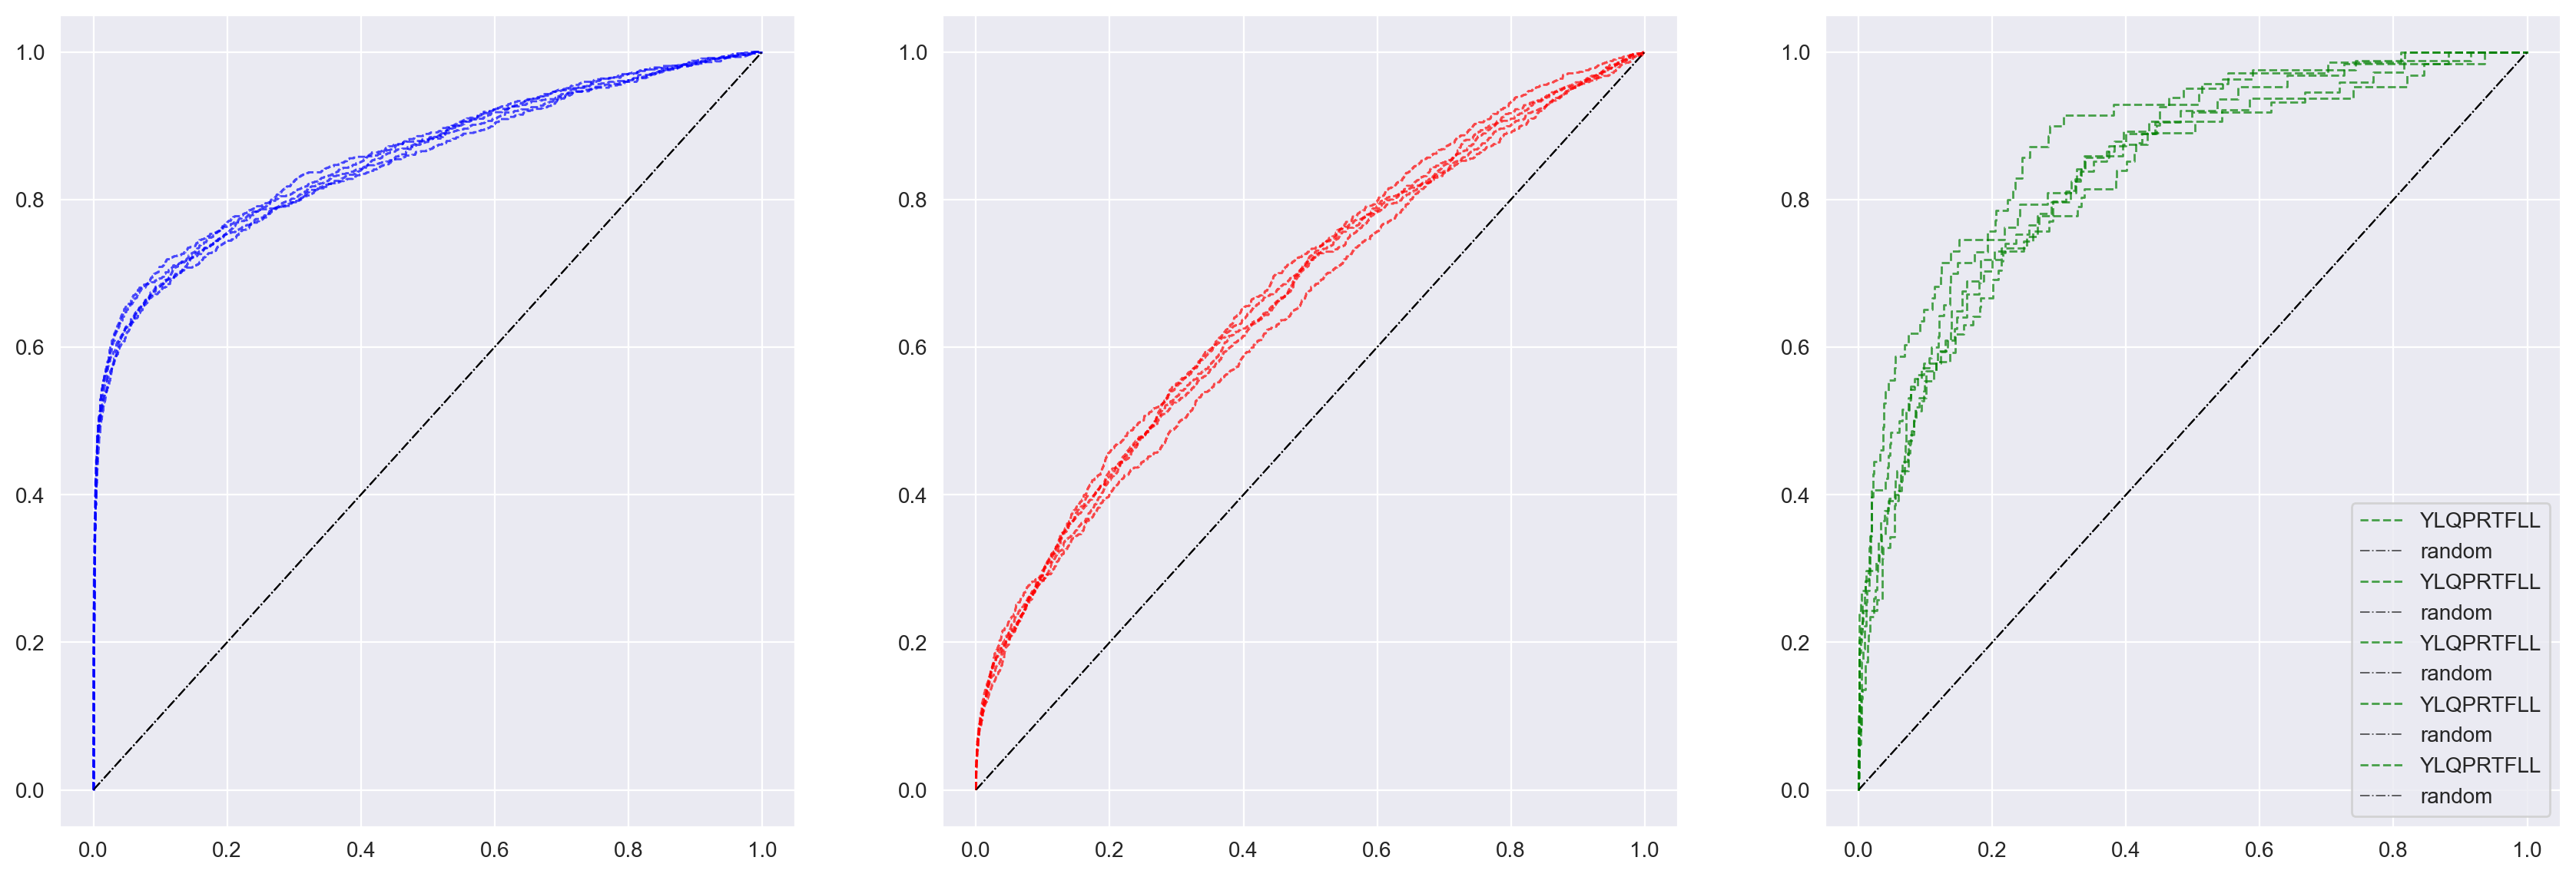

In [200]:
from scipy import interp
from numpy import interp

f,a = plt.subplots(1,3, figsize=(21,7))
c = ['b--', 'r--', 'g--']

all_tprs = {}
for i, epitope in enumerate(kfold_nn.keys()):
    print(epitope)
    tprs = []
    mean_len_ = int(np.mean([len(kfold_nn[epitope][k][0][0]) for k in kfold_nn[epitope].keys()]))
    print(mean_len_)
    for k in kfold_nn[epitope].keys():
        # 3 elements in the curve tuple
        FPR = kfold_nn[epitope][k][0][0] #1st curve
        TPR = kfold_nn[epitope][k][0][1] #2nd curve
        #_ = logregVAE[epitope][k][0][2] #Useless thresholds
        #curve_0 = np.concatenate([curve_0, roc_curve_0], axis=1)
        a[i].plot(FPR, TPR,c[i], alpha = 0.7, lw = 1 , label = epitope)
        base = np.linspace(0,1,mean_len_)
        a[i].plot(base, base, 'k-.', alpha = 0.6, lw = .7, label = 'random')
        TPR = interp(base, FPR, TPR)
        TPR[0] = 0.0
        tprs.append(TPR)
    all_tprs[epitope] = tprs
    plt.legend()
    

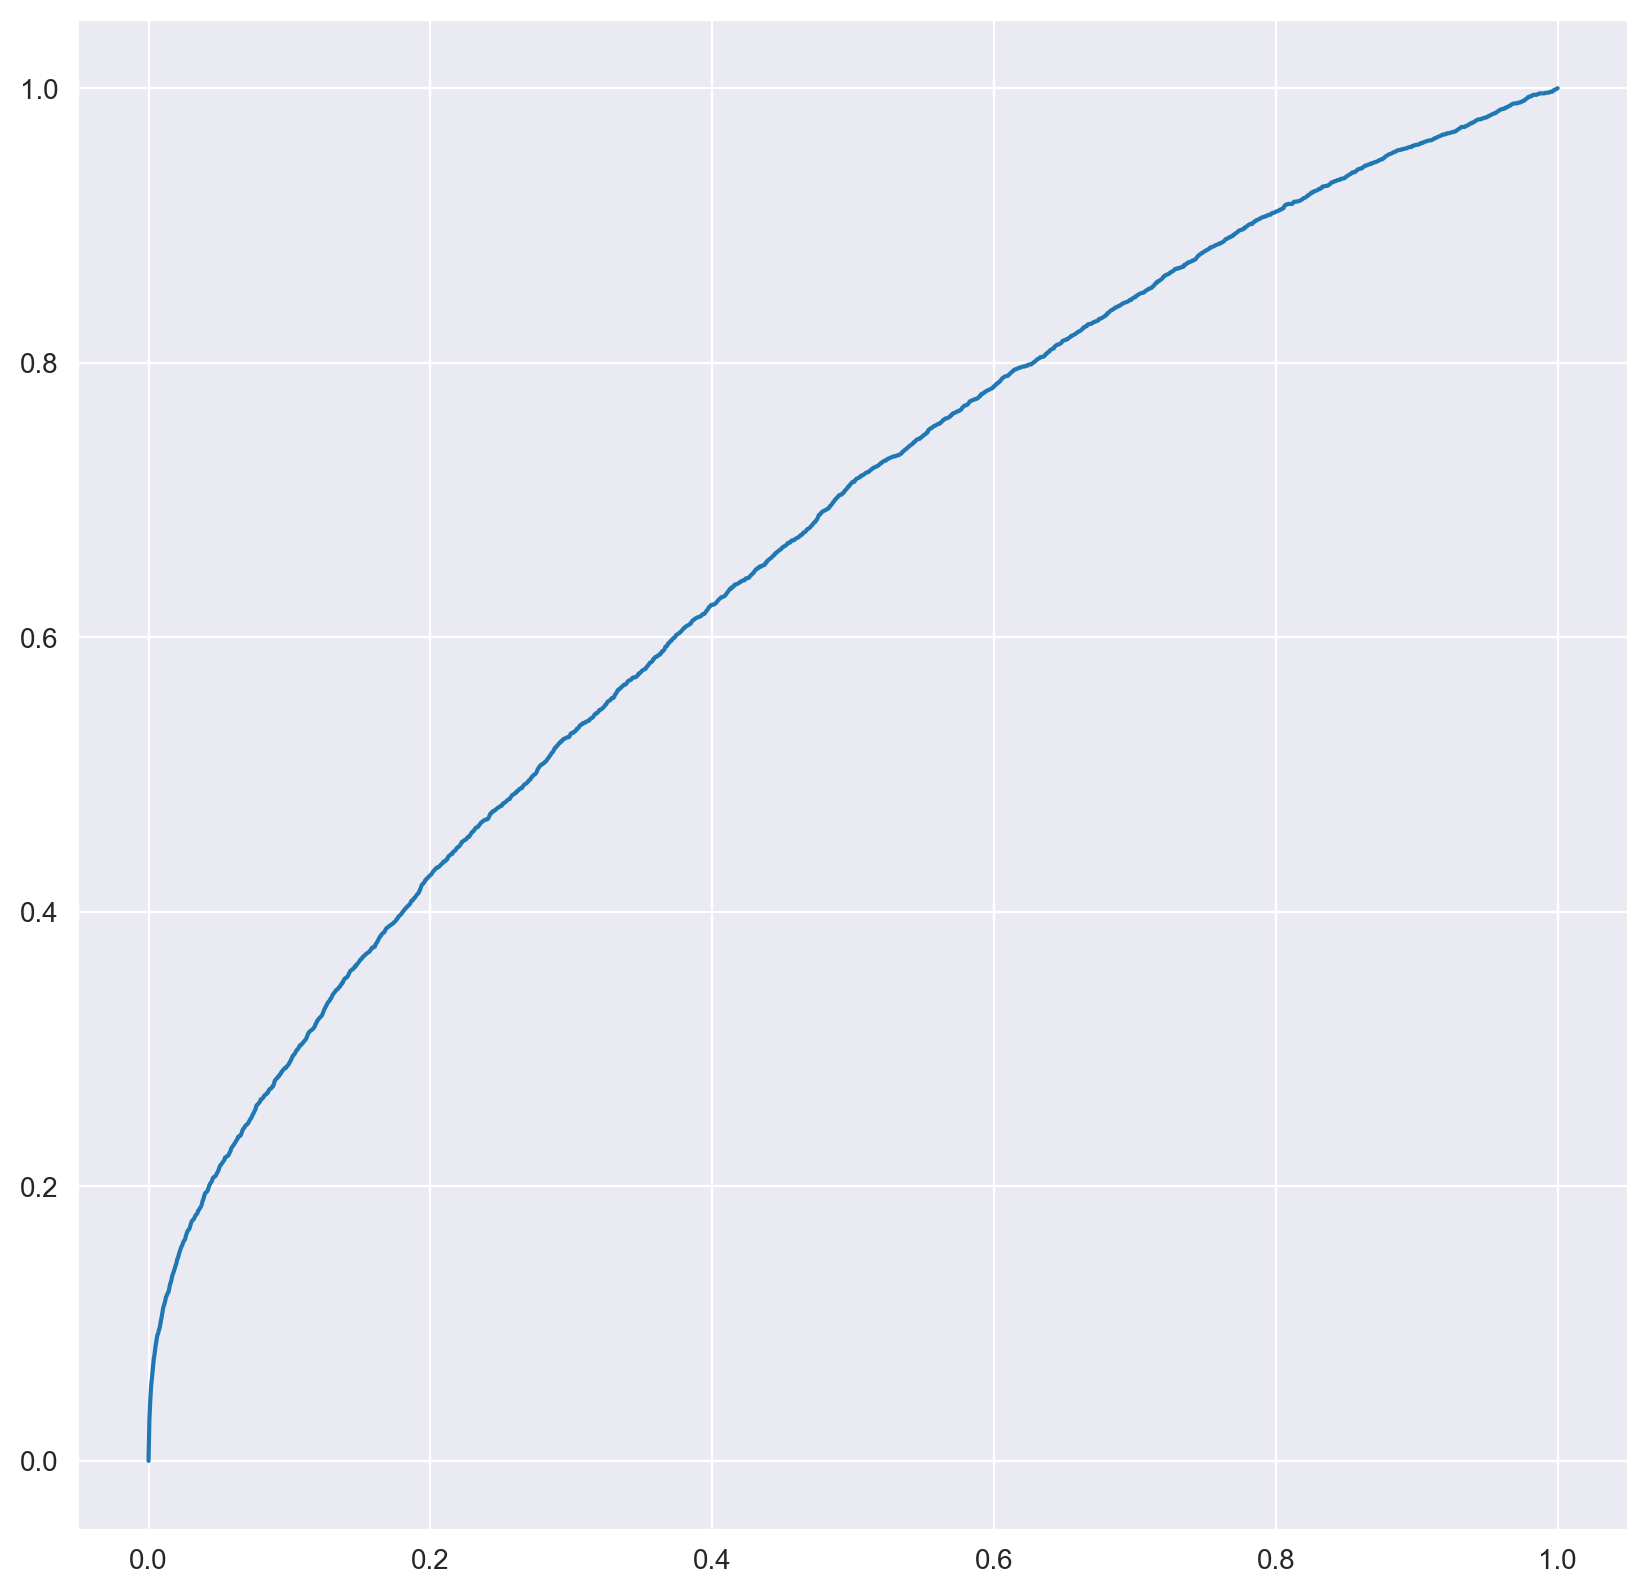

In [207]:
gil_tprs = np.array(all_tprs['NLVPMVATV'])
gil_mean = gil_tprs.mean(axis=0)
gil_std = gil_tprs.std(axis=0)
plt.figure(figsize=(10,10))
#Linspace to plot the curve in [0, 1]
plt.plot(np.linspace(0,1, len(gil_mean)),gil_mean)

# see this link : interp to get plot with different lengths ROC CURVEs
https://stats.stackexchange.com/questions/186337/average-roc-for-repeated-10-fold-cross-validation-with-probability-estimates 

33
30
44
32
32


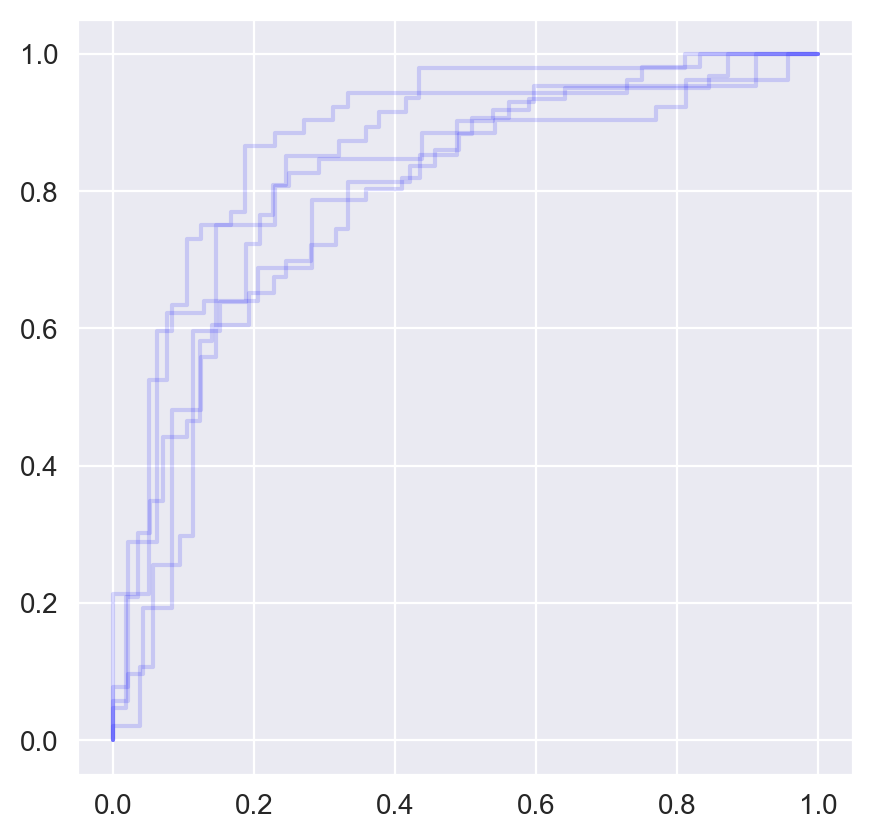

In [134]:
#code snippet from the link 
import matplotlib.pyplot as plt
import numpy as np
from scipy import interp

from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve

X, y = make_classification(n_samples=500, random_state=100, flip_y=0.3)

kf = KFold(n_splits = 5, shuffle=True, random_state = 20)

tprs = []
base_fpr = np.linspace(0, 1, 101)

plt.figure(figsize=(5, 5))
roc_curve()
for i, (train, test) in enumerate(kf.split(X)):
    model = LogisticRegression().fit(X[train], y[train])
    y_score = model.predict_proba(X[test])
    fpr, tpr, _ = roc_curve(y[test], y_score[:, 1])
    print(len(fpr))
    plt.plot(fpr, tpr, 'b', alpha=0.15)
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)

#tprs = np.array(tprs)
#mean_tprs = tprs.mean(axis=0)
#std = tprs.std(axis=0)
#
#tprs_upper = np.minimum(mean_tprs + std, 1)
#tprs_lower = mean_tprs - std
#
#
#plt.plot(base_fpr, mean_tprs, 'b')
#plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
#
#plt.plot([0, 1], [0, 1],'r--')
#plt.xlim([-0.01, 1.01])
#plt.ylim([-0.01, 1.01])
#plt.ylabel('True Positive Rate')
#plt.xlabel('False Positive Rate')
#plt.axes().set_aspect('equal', 'datalim')
#plt.show()